In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses
from keras.datasets import mnist

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

class EpochVariableCallback(Callback) :
    
    def __init__(self, my_variable, my_func) :
        self.my_variable = my_variable       
        self.my_func = my_func
        
    def on_epoch_begin(self, epoch, logs={}) :
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))


Using TensorFlow backend.


In [2]:
#Load MNIST data

dataset_name = "mnist_3_vs_5"

img_rows, img_cols = 28, 28

num_classes = 10
batch_size = 32

included_classes = { 3, 5 }

(x_train, y_train), (x_test, y_test) = mnist.load_data()

keep_index_train = []
for i in range(y_train.shape[0]) :
    if y_train[i] in included_classes :
        keep_index_train.append(i)

keep_index_test = []
for i in range(y_test.shape[0]) :
    if y_test[i] in included_classes :
        keep_index_test.append(i)

x_train = x_train[keep_index_train]
x_test = x_test[keep_index_test]
y_train = y_train[keep_index_train]
y_test = y_test[keep_index_test]

n_train = int((x_train.shape[0] // batch_size) * batch_size)
n_test = int((x_test.shape[0] // batch_size) * batch_size)
x_train = x_train[:n_train]
x_test = x_test[:n_test]
y_train = y_train[:n_train]
y_test = y_test[:n_test]


x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print("x_train.shape = " + str(x_train.shape))

print("n train samples = " + str(x_train.shape[0]))
print("n test samples = " + str(x_test.shape[0]))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#Binarize images

def _binarize_images(x, val_thresh=0.5) :
    
    x_bin = np.zeros(x.shape)
    x_bin[x >= val_thresh] = 1.
    
    return x_bin

x_train = _binarize_images(x_train, val_thresh=0.5)
x_test = _binarize_images(x_test, val_thresh=0.5)


x_train.shape = (11552, 28, 28, 1)
n train samples = 11552
n test samples = 1888


In [3]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/binary-stochastic-neurons-in-tensorflow.html
#See Github https://github.com/spitis/

def bernoulli_sample(x):
    g = tf.get_default_graph()
    with ops.name_scope("BernoulliSample") as name:
        with g.gradient_override_map({"Ceil": "Identity","Sub": "BernoulliSample_ST"}):
            return tf.ceil(x - tf.random_uniform(tf.shape(x)), name=name)

@ops.RegisterGradient("BernoulliSample_ST")
def bernoulliSample_ST(op, grad):
    return [grad, tf.zeros(tf.shape(op.inputs[1]))]


In [9]:
#Scrambler network definition

#Gumbel Distribution Sampler
def gumbel_softmax(logits, temperature=0.5) :
    gumbel_dist = tf.contrib.distributions.RelaxedOneHotCategorical(temperature, logits=logits)
    batch_dim = logits.get_shape().as_list()[0]
    onehot_dim = logits.get_shape().as_list()[1]
    return gumbel_dist.sample()

def sample_mask_gumbel(pwm_logits) :
    n_sequences = K.shape(pwm_logits)[0]
    x_len = K.shape(pwm_logits)[1]
    y_len = K.shape(pwm_logits)[2]

    flat_pwm = K.reshape(pwm_logits, (n_sequences * x_len * y_len, 2))
    sampled_pwm = gumbel_softmax(flat_pwm, temperature=0.5)

    return K.reshape(sampled_pwm, (n_sequences, x_len, y_len, 2))[..., :1]

def make_resblock(n_channels=64, window_size=8, dilation_rate=1, group_ix=0, layer_ix=0, drop_rate=0.0, batchnorm_trainmode=True) :

    #Initialize res block layers
    batch_norm_0 = BatchNormalization(name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_0')

    relu_0 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_0 = Conv2D(n_channels, (window_size, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_0')

    batch_norm_1 = BatchNormalization(name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_batch_norm_1')

    relu_1 = Lambda(lambda x: K.relu(x, alpha=0.0))

    conv_1 = Conv2D(n_channels, (window_size, window_size), dilation_rate=dilation_rate, strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_conv_1')

    skip_1 = Lambda(lambda x: x[0] + x[1], name='scrambler_resblock_' + str(group_ix) + '_' + str(layer_ix) + '_skip_1')

    drop_1 = None
    if drop_rate > 0.0 :
        drop_1 = Dropout(drop_rate)
    
    #Execute res block
    def _resblock_func(input_tensor, training=batchnorm_trainmode) :
        batch_norm_0_out = batch_norm_0(input_tensor, training=training)
        relu_0_out = relu_0(batch_norm_0_out)
        conv_0_out = conv_0(relu_0_out)

        batch_norm_1_out = batch_norm_1(conv_0_out, training=training)
        relu_1_out = relu_1(batch_norm_1_out)
        
        if drop_rate > 0.0 :
            conv_1_out = drop_1(conv_1(relu_1_out))
        else :
            conv_1_out = conv_1(relu_1_out)

        skip_1_out = skip_1([conv_1_out, input_tensor])
        
        return skip_1_out

    return _resblock_func

def load_scrambler_network(n_groups=1, n_resblocks_per_group=4, n_channels=32, window_size=8, dilation_rates=[1], drop_rate=0.0, batchnorm_trainmode=True) :

    #Discriminator network definition
    conv_0 = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_conv_0')
    
    skip_convs = []
    resblock_groups = []
    for group_ix in range(n_groups) :
        
        skip_convs.append(Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_skip_conv_' + str(group_ix)))
        
        resblocks = []
        for layer_ix in range(n_resblocks_per_group) :
            resblocks.append(make_resblock(n_channels=n_channels, window_size=window_size, dilation_rate=dilation_rates[group_ix], group_ix=group_ix, layer_ix=layer_ix, drop_rate=drop_rate, batchnorm_trainmode=batchnorm_trainmode))
        
        resblock_groups.append(resblocks)

    last_block_conv = Conv2D(n_channels, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_last_block_conv')
    
    skip_add = Lambda(lambda x: x[0] + x[1], name='scrambler_skip_add')
    
    
    final_conv_2_channels = Conv2D(2, (1, 1), strides=(1, 1), padding='same', activation='linear', kernel_initializer='glorot_normal', name='scrambler_final_conv')
    
    final_conv_sigm = Lambda(lambda x: K.softmax(x, axis=-1)[..., :1])
    final_conv_gumbel = Lambda(lambda x: sample_mask_gumbel(x))
    
    scale_inputs = Lambda(lambda x: x[1] * K.tile(x[0], (1, 1, 1, 1)), name='scrambler_input_scale')
    
    def _scrambler_func(image_input) :
        conv_0_out = conv_0(image_input)

        #Connect group of res blocks
        output_tensor = conv_0_out

        #Res block group execution
        skip_conv_outs = []
        for group_ix in range(n_groups) :
            skip_conv_out = skip_convs[group_ix](output_tensor)
            skip_conv_outs.append(skip_conv_out)

            for layer_ix in range(n_resblocks_per_group) :
                output_tensor = resblock_groups[group_ix][layer_ix](output_tensor)
        
        #Last res block extr conv
        last_block_conv_out = last_block_conv(output_tensor)

        skip_add_out = last_block_conv_out
        for group_ix in range(n_groups) :
            skip_add_out = skip_add([skip_add_out, skip_conv_outs[group_ix]])

        #Final conv out
        final_conv_2_channels_out = final_conv_2_channels(skip_add_out)
        
        final_conv_sigm_out = final_conv_sigm(final_conv_2_channels_out)
        final_conv_gumbel_out = final_conv_gumbel(final_conv_2_channels_out)
        
        #Scale inputs by importance scores
        scaled_inputs = scale_inputs([final_conv_gumbel_out, image_input])
        
        return scaled_inputs, final_conv_sigm_out, final_conv_2_channels_out

    return _scrambler_func


In [14]:
#Keras loss functions

def get_softmax_kl_divergence() :

    def _softmax_kl_divergence(y_true, y_pred) :

        y_true = K.clip(y_true, K.epsilon(), 1.0 - K.epsilon())
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())

        return K.mean(K.sum(y_true * K.log(y_true / y_pred), axis=-1), axis=-1)
    
    return _softmax_kl_divergence

def get_margin_lum_ame_masked(max_lum=0.1) :
    
    def _margin_lum_ame(importance_scores) :
        p_ons = importance_scores[..., 0]
        
        mean_p_on = K.mean(p_ons, axis=(1, 2))

        margin_p_on = K.switch(mean_p_on > max_lum, mean_p_on - max_lum, K.zeros_like(mean_p_on))
    
        return margin_p_on
    
    return _margin_lum_ame

def get_target_lum_sme_masked(target_lum=0.1) :
    
    def _target_lum_sme(importance_scores) :
        p_ons = importance_scores[..., 0]
        
        mean_p_on = K.mean(p_ons, axis=(1, 2))
        
        return (mean_p_on - target_lum)**2
    
    return _target_lum_sme

def get_weighted_loss(loss_coeff=1.) :
    
    def _min_pred(y_true, y_pred) :
        return loss_coeff * y_pred
    
    return _min_pred


In [11]:
#Initialize Encoder and Decoder networks
batch_size = 32
n_rows = 28
n_cols = 28

#Resnet parameters
resnet_n_groups = 5
resnet_n_resblocks_per_group = 4
resnet_n_channels = 32
resnet_window_size = 3
resnet_dilation_rates = [1, 2, 4, 2, 1]
resnet_drop_rate = 0.0#0.25
resnet_batchnorm_trainmode = True

#Load scrambler
scrambler = load_scrambler_network(
    n_groups=resnet_n_groups,
    n_resblocks_per_group=resnet_n_resblocks_per_group,
    n_channels=resnet_n_channels, window_size=resnet_window_size,
    dilation_rates=resnet_dilation_rates,
    drop_rate=resnet_drop_rate,
    batchnorm_trainmode=resnet_batchnorm_trainmode
)


In [12]:
#Load Predictor
predictor_path = 'saved_models/mnist_binarized_cnn_10_digits.h5'

predictor = load_model(predictor_path)

predictor.trainable = False
predictor.compile(optimizer=keras.optimizers.SGD(lr=0.1), loss='mean_squared_error')


In [13]:
#Build scrambler model
scrambler_input = Input(shape=(n_rows, n_cols, 1), name='scrambler_input')

image, importance_scores, importance_scores_log = scrambler(scrambler_input)

scrambler_model = Model([scrambler_input], [image, importance_scores, importance_scores_log])

scrambler_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss='mean_squared_error'
)


In [16]:
#Build Auto-scrambler pipeline

#Define model inputs
ae_scrambler_input = Input(shape=(n_rows, n_cols, 1), name='ae_scrambler_input')

#Run encoder and decoder
scrambled_sample, importance_scores, importance_scores_log = scrambler(ae_scrambler_input)

#Make reference prediction on non-scrambled input sequence
y_pred_non_scrambled = predictor([ae_scrambler_input])

#Make prediction on scrambled sequence samples
y_pred_scrambled = predictor([scrambled_sample])

#Cost function parameters
initial_target_lum = 0.25
target_lum = 0.05

#NLL cost
nll_loss_func = get_softmax_kl_divergence()

#Conservation cost
conservation_loss_func = get_target_lum_sme_masked(target_lum=initial_target_lum)

#Entropy cost
entropy_loss_func = get_target_lum_sme_masked(target_lum=target_lum)
#entropy_loss_func = get_margin_lum_ame_masked(max_lum=target_lum)

#Define annealing coefficient
anneal_coeff = K.variable(1.0)

#Execute NLL cost
nll_loss = Lambda(lambda x: nll_loss_func(x[0], x[1]), name='nll')([y_pred_non_scrambled, y_pred_scrambled])

#Execute conservation cost
conservation_loss = Lambda(lambda x: anneal_coeff * conservation_loss_func(x), name='conservation')(importance_scores)

#Execute entropy cost
entropy_loss = Lambda(lambda x: (1. - anneal_coeff) * entropy_loss_func(x), name='entropy')(importance_scores)

loss_model = Model(
    [ae_scrambler_input],
    [nll_loss, conservation_loss, entropy_loss]
)

loss_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.9),
    loss={
        'nll' : get_weighted_loss(loss_coeff=1.0),
        'conservation' : get_weighted_loss(loss_coeff=1.0),
        'entropy' : get_weighted_loss(loss_coeff=500.0)
    }
)


In [17]:
scrambler_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scrambler_input (InputLayer)    (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
scrambler_conv_0 (Conv2D)       (None, 28, 28, 32)   64          scrambler_input[0][0]            
__________________________________________________________________________________________________
scrambler_resblock_0_0_batch_no (None, 28, 28, 32)   128         scrambler_conv_0[0][0]           
__________________________________________________________________________________________________
lambda_43 (Lambda)              (None, 28, 28, 32)   0           scrambler_resblock_0_0_batch_norm
__________________________________________________________________________________________________
scrambler_

In [18]:
loss_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ae_scrambler_input (InputLayer) (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
scrambler_conv_0 (Conv2D)       (None, 28, 28, 32)   64          ae_scrambler_input[0][0]         
__________________________________________________________________________________________________
scrambler_resblock_0_0_batch_no (None, 28, 28, 32)   128         scrambler_conv_0[2][0]           
__________________________________________________________________________________________________
lambda_43 (Lambda)              (None, 28, 28, 32)   0           scrambler_resblock_0_0_batch_norm
__________________________________________________________________________________________________
scrambler_

scrambler_resblock_3_3_batch_no (None, 28, 28, 32)   128         scrambler_resblock_3_2_skip_1[2][
__________________________________________________________________________________________________
lambda_73 (Lambda)              (None, 28, 28, 32)   0           scrambler_resblock_3_3_batch_norm
__________________________________________________________________________________________________
scrambler_resblock_3_3_conv_0 ( (None, 28, 28, 32)   9248        lambda_73[2][0]                  
__________________________________________________________________________________________________
scrambler_resblock_3_3_batch_no (None, 28, 28, 32)   128         scrambler_resblock_3_3_conv_0[2][
__________________________________________________________________________________________________
lambda_74 (Lambda)              (None, 28, 28, 32)   0           scrambler_resblock_3_3_batch_norm
__________________________________________________________________________________________________
scrambler_

In [20]:
#Training configuration

#Define number of training epochs
n_epochs = 50

#Define experiment suffix (optional)
experiment_suffix = "_kl_divergence_higher_entropy_penalty_gumbel_no_bg_lum"

#Define anneal function
def _anneal_func(val, epoch, n_epochs=n_epochs) :
    if epoch in [0] :
        return 1.0
    
    return 0.0

architecture_str = "resnet_" + str(resnet_n_groups) + "_" + str(resnet_n_resblocks_per_group) + "_" + str(resnet_n_channels) + "_" + str(resnet_window_size) + "_" + str(resnet_drop_rate).replace(".", "")

model_name = "autoscrambler_dataset_" + dataset_name + "_" + architecture_str + "_n_epochs_" + str(n_epochs) + "_target_lum_" + str(target_lum).replace(".", "") + experiment_suffix

print("Model save name = " + model_name)


Model save name = autoscrambler_dataset_mnist_3_vs_5_resnet_5_4_32_3_00_n_epochs_50_target_lum_005_kl_divergence_higher_entropy_penalty_gumbel_no_bg_lum


In [22]:
#Execute training procedure

callbacks =[
    #ModelCheckpoint("model_checkpoints/" + model_name + "_epoch_{epoch:02d}.hdf5", monitor='val_loss', mode='min', period=10, save_weights_only=True),
    EpochVariableCallback(anneal_coeff, _anneal_func)
]

s_train = np.zeros((x_train.shape[0], 1))
s_test = np.zeros((x_test.shape[0], 1))

# train the autoencoder
train_history = loss_model.fit(
    [x_train],
    [s_train, s_train, s_train],
    shuffle=True,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(
        [x_test],
        [s_test, s_test, s_test]
    ),
    callbacks=callbacks
)


Train on 11552 samples, validate on 1888 samples
Epoch 1/50
11552/11552 [==============================] - 119s 10ms/step - loss: 0.1296 - nll_loss: 0.1159 - conservation_loss: 0.0137 - entropy_loss: 0.0000e+00 - val_loss: 0.0122 - val_nll_loss: 0.0081 - val_conservation_loss: 0.0041 - val_entropy_loss: 0.0000e+00
Epoch 2/50
11552/11552 [==============================] - 95s 8ms/step - loss: 0.3771 - nll_loss: 0.1910 - conservation_loss: 0.0000e+00 - entropy_loss: 0.1860 - val_loss: 0.1044 - val_nll_loss: 0.0818 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 0.0226
Epoch 3/50
11552/11552 [==============================] - 95s 8ms/step - loss: 0.1606 - nll_loss: 0.1319 - conservation_loss: 0.0000e+00 - entropy_loss: 0.0286 - val_loss: 0.0592 - val_nll_loss: 0.0377 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 0.0215
Epoch 4/50
11552/11552 [==============================] - 95s 8ms/step - loss: 0.1453 - nll_loss: 0.1198 - conservation_loss: 0.0000e+00 - entropy_loss: 0

Epoch 32/50
11552/11552 [==============================] - 95s 8ms/step - loss: 0.1037 - nll_loss: 0.0923 - conservation_loss: 0.0000e+00 - entropy_loss: 0.0115 - val_loss: 0.0352 - val_nll_loss: 0.0168 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 0.0183
Epoch 33/50
11552/11552 [==============================] - 95s 8ms/step - loss: 0.1021 - nll_loss: 0.0895 - conservation_loss: 0.0000e+00 - entropy_loss: 0.0126 - val_loss: 0.0601 - val_nll_loss: 0.0239 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 0.0362
Epoch 34/50
11552/11552 [==============================] - 95s 8ms/step - loss: 0.1055 - nll_loss: 0.0938 - conservation_loss: 0.0000e+00 - entropy_loss: 0.0117 - val_loss: 0.0373 - val_nll_loss: 0.0224 - val_conservation_loss: 0.0000e+00 - val_entropy_loss: 0.0150
Epoch 35/50
11552/11552 [==============================] - 94s 8ms/step - loss: 0.1090 - nll_loss: 0.0956 - conservation_loss: 0.0000e+00 - entropy_loss: 0.0134 - val_loss: 0.0329 - val_nll_loss: 0.0211

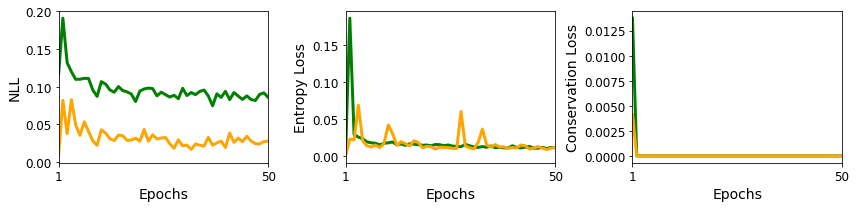

In [23]:

save_figs = False

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3 * 4, 3))

n_epochs_actual = len(train_history.history['nll_loss'])

ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['nll_loss'], linewidth=3, color='green')
ax1.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_nll_loss'], linewidth=3, color='orange')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['entropy_loss'], linewidth=3, color='green')
ax2.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_entropy_loss'], linewidth=3, color='orange')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

ax3.plot(np.arange(1, n_epochs_actual + 1), train_history.history['conservation_loss'], linewidth=3, color='green')
ax3.plot(np.arange(1, n_epochs_actual + 1), train_history.history['val_conservation_loss'], linewidth=3, color='orange')

plt.sca(ax3)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Conservation Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig(model_name + "_loss.png", transparent=True, dpi=300)
    plt.savefig(model_name + "_loss.eps")

plt.show()


In [24]:
# Save model and weights
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')

scrambler_model.save(model_path)
print('Saved scrambler model at %s ' % (model_path))


Saved scrambler model at saved_models/autoscrambler_dataset_mnist_3_vs_5_resnet_5_4_32_3_00_n_epochs_50_target_lum_005_kl_divergence_higher_entropy_penalty_gumbel_no_bg_lum.h5 


In [25]:
#Load models
save_dir = 'saved_models'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name + '.h5')
scrambler_model = load_model(model_path, custom_objects={
    'bernoulli_sample' : bernoulli_sample,
    'tf' : tf,
    'sample_mask_gumbel' : sample_mask_gumbel
})

print('Loaded scrambler model %s ' % (model_path))


Loaded scrambler model saved_models/autoscrambler_dataset_mnist_3_vs_5_resnet_5_4_32_3_00_n_epochs_50_target_lum_005_kl_divergence_higher_entropy_penalty_gumbel_no_bg_lum.h5 


Test image 0:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.99]


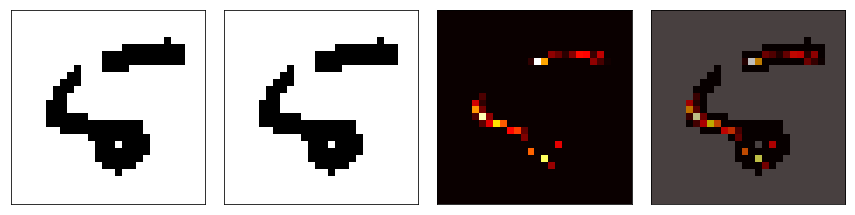

Test image 1:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.9]


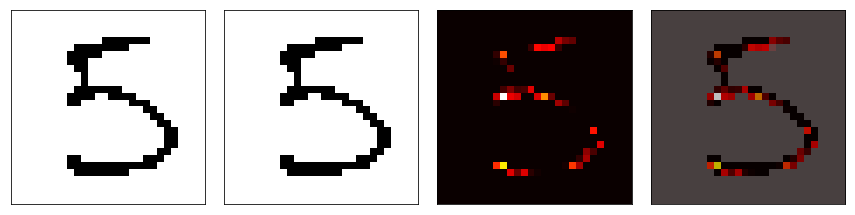

Test image 2:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [0.98]


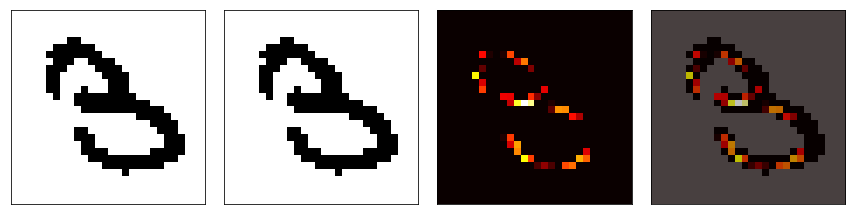

Test image 3:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [1.0]


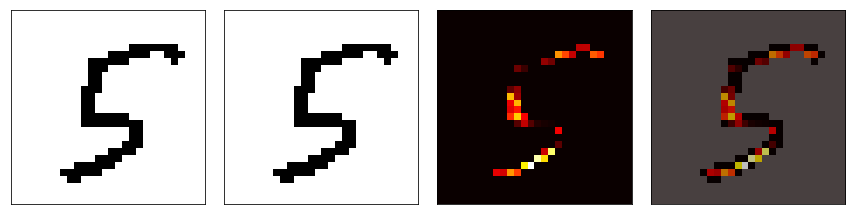

Test image 4:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [1.0]


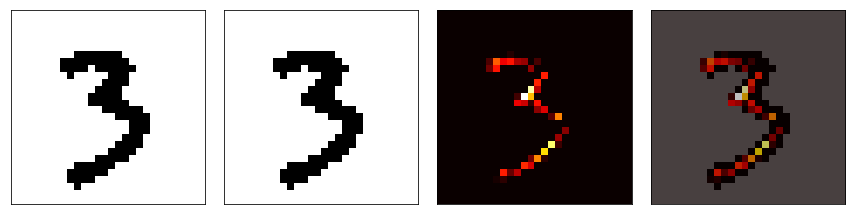

Test image 5:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [1.0]


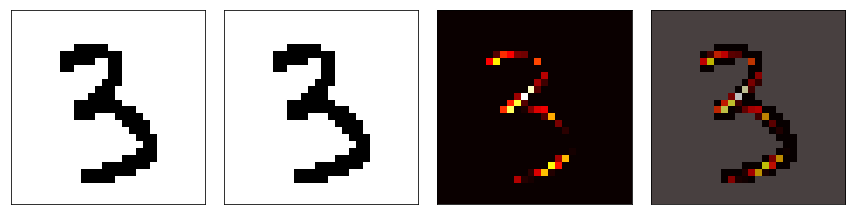

Test image 6:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [1.0]


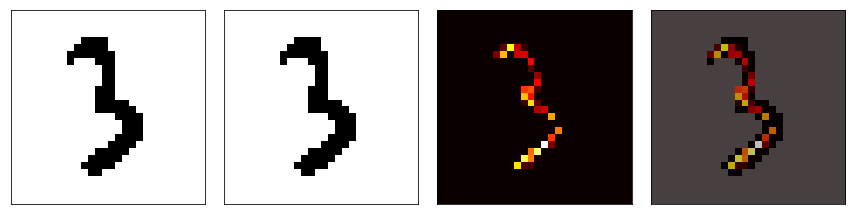

Test image 7:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [1.0]


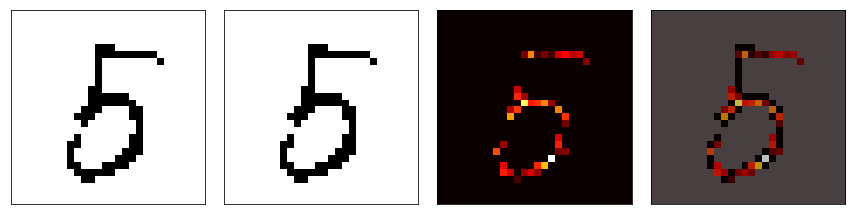

Test image 8:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [1.0]


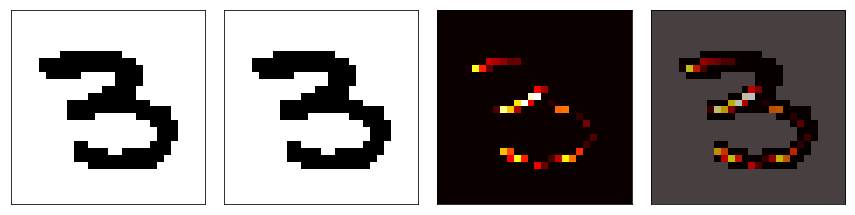

Test image 9:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [1.0]


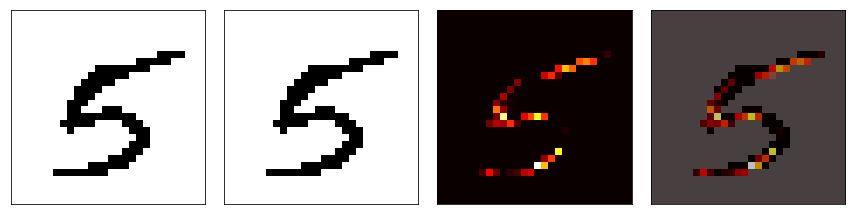

Test image 10:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [1.0]


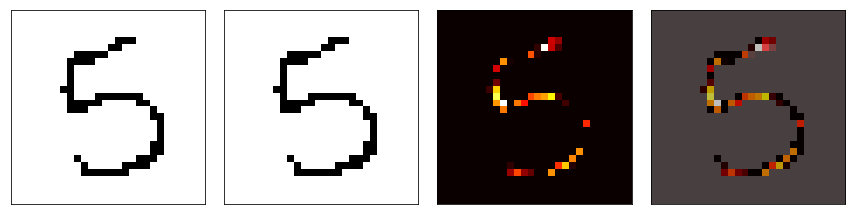

Test image 11:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [1.0]


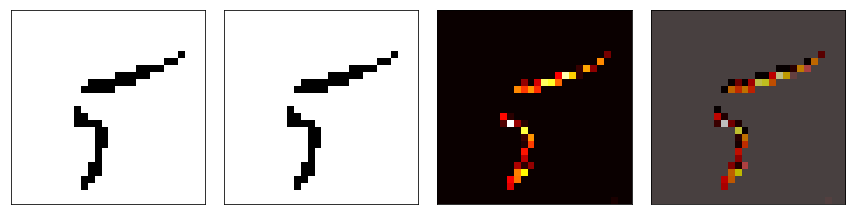

Test image 12:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [1.0]


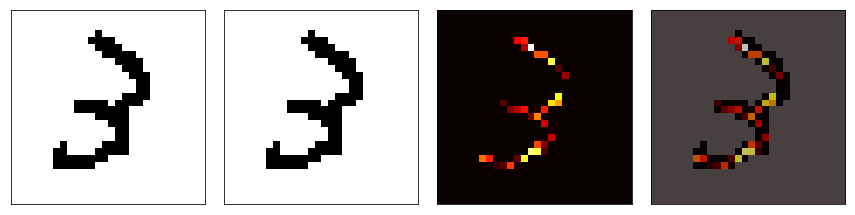

Test image 13:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [1.0]


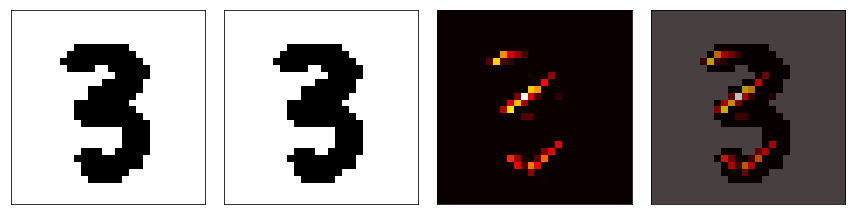

Test image 14:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [1.0]


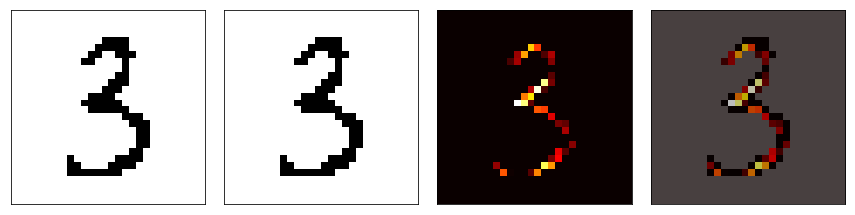

Test image 15:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [1.0]


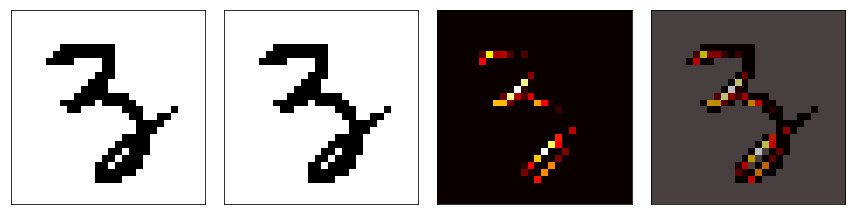

Test image 16:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [1.0]


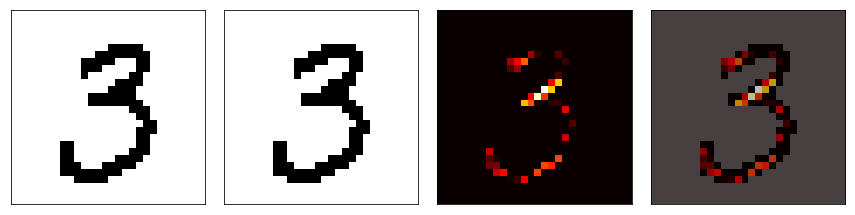

Test image 17:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [1.0]


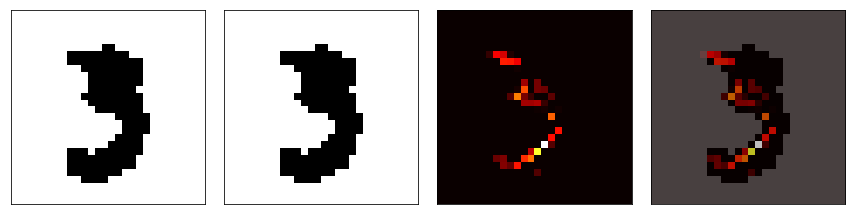

Test image 18:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [1.0]


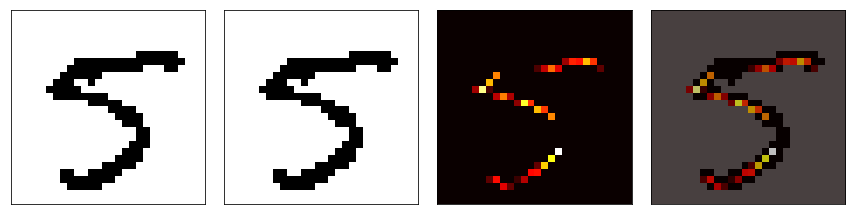

Test image 19:
 - Prediction (original) = 1.0
 - Predictions (scrambled) = [1.0]


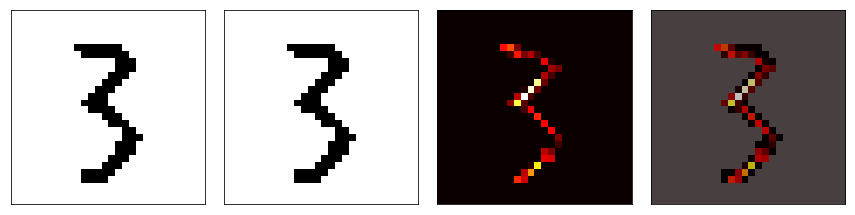

In [29]:
#Visualize a few reconstructed images

from numpy.ma import masked_array

digit_test = np.argmax(y_test, axis=1)

s_test = np.zeros((x_test.shape[0], 1))

sample_test, importance_scores_test, importance_scores_log_test = scrambler_model.predict_on_batch(x=[x_test[:32]])

importance_scores_test = (importance_scores_log_test[..., 0] - np.mean(importance_scores_log_test, axis=-1))[..., None]

save_images = [3, 4]

for plot_i in range(0, 20) :
    
    print("Test image " + str(plot_i) + ":")
    
    y_test_hat_ref = predictor.predict(x=[np.expand_dims(x_test[plot_i], axis=0)], batch_size=1)[0, digit_test[plot_i]]
    y_test_hat = predictor.predict(x=[sample_test[plot_i:plot_i+1]], batch_size=1)[:, digit_test[plot_i]].tolist()
    
    print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])
    print(" - Predictions (scrambled) = " + str([float(str(round(y_test_hat[i], 2))[:4]) for i in range(len(y_test_hat))]))
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3 * 4, 3))

    ax1.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax1)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax2.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax2)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax3.imshow(importance_scores_test[plot_i, :, :, 0], cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax3)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax4.imshow(x_test[plot_i, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

    plt.sca(ax4)
    plt.xticks([], [])
    plt.yticks([], [])
    
    ax4.imshow(importance_scores_test[plot_i, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[plot_i, :, :, 0]), aspect='equal')

    plt.sca(ax4)
    plt.xticks([], [])
    plt.yticks([], [])

    plt.tight_layout()
    
    if save_images is not None and plot_i in save_images :
        plt.savefig(model_name + "_test_example_" + str(plot_i) + ".png", transparent=True, dpi=300)
        plt.savefig(model_name + "_test_example_" + str(plot_i) + ".eps")
    
    plt.show()


In [30]:
#Visualize a few reconstructed images

digit_test = np.argmax(y_test, axis=1)

s_test = np.zeros((x_test.shape[0], 1))

sample_test, importance_scores_test, importance_scores_log_test = scrambler_model.predict(x=[x_test], batch_size=32, verbose=True)

importance_scores_test = (importance_scores_log_test[..., 0] - np.mean(importance_scores_log_test, axis=-1))[..., None]


1888/1888 [==============================] - 4s 2ms/step


In [31]:
#Save predicted importance scores

np.save(model_name + "_importance_scores_test", importance_scores_test)
